In [3]:
import torch
import torch.nn as nn
import torchvision

import torch.optim as optim
from torch.utils.data import DataLoader,Dataset

import torchvision.transforms as transforms
from PIL import Image

from tqdm import tqdm
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## download dataset

In [2]:
! wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz && tar -xzf ./maps.tar.gz

--2022-01-30 13:39:57--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M   969KB/s    in 2m 33s  

2022-01-30 13:42:31 (1.56 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]



## define models

<img src="./../img/pix2pix.png">

<img src="./../img/unet.png" width=720>

first, we need to keep in mind that: pix2pix need an input x and according label

pix2pix's generator:
1. take a x (N, 3, 256, 256) as input to generate a according img (N, 3, 256, 256)
2. we then put the x and output into disc

discriminator:
1. we will put the x and the generated fake image or the label into disc
2. the disc will output a patch (N, 1, 30, 30)
3. we use the simple GAN loss to do gradient descent

the architecture of discriminator is nothing new, what is different from simple GAN is: Simple GAN output a single scalar, while pix2pix output a patch to indicate the specific part of generated image is fake or not.

the architecture of gen is much like the unet, 1. having the down block and the up block 2. concat previous layer's output and current layer's output and put them into conv layers.

the last thing to mention is that: the loss of gen is made up of two parts:
1. the common disc out part
2. use a L1 LOSS between generated image and label to make the fake image more implict

In [16]:
class Gen(nn.Module):
    """
    input: (N, 3, 256, 256) input image
    output: (N, 3, 256, 256) image generated

    arch:
          (N, 3, 256, 256)
                ||
                \/
        1. init_down
          (N, 64, 128, 128) (*1)
                ||
                \/
        2. down_block
        # (N, 128, 64, 64) (*2)
        # (N, 256, 32, 32) (*3)
        # (N, 512, 16, 16) (*4)
        # (N, 512, 8, 8)   (*5)
        # (N, 512, 4, 4)   (*6)
        #(N, 512, 2, 2)    (*7)
                ||
                \/ 
        3. bottleneck
          (N, 512, 1, 1)
                ||
                \/
        4. up_block
           conv  out         |      concat with
        (N, 512, 2, 2)       |    (*7) (N, 1024, 2, 2)
        (N, 512, 4, 4)       |    (*6) (N, 1024, 4, 4)
        (N, 512, 8, 8)       |    (*5) (N, 1024, 8, 8)
        (N, 512, 16, 16)     |    (*4) (N, 1024, 16, 16)
        (N, 256, 32, 32)     |    (*3) (N, 512, 32, 32)
        (N, 128, 64, 64)     |    (*2) (N, 256, 64, 64)
        (N, 64, 128, 128)    |    (*1) (N, 128, 128, 128)
                ||
                \/
        5. final_up
          (N, 3, 256, 256)  

    """
    def __init__(self, img_channel) -> None:
        super(Gen, self).__init__()
        # input: (N, 3, 256, 256)
        self.init_down = nn.Sequential(
            nn.Conv2d(img_channel, 64, (4,4), (2,2), 1),
            nn.LeakyReLU(0.2))
        self.down_lst = [64, 128, 256, 512, 512, 512, 512]
        self.bottleneck = self._conv_block(512, 512, 4, 2, 1, norm=False, dropout=0.5)
        self.up_lst = [[512, 512],
                 [512*2, 512],
                 [512*2, 512],
                 [512*2, 512],
                 [512*2, 256],
                 [256*2, 128],
                 [128*2, 64]]

        self.final_up = nn.Sequential(
            nn.Upsample(size=256),
            nn.Conv2d(64*2, img_channel, 3, 1, 1),
            nn.Tanh()
        )

        self.down_layers = self._down_block()
        self.up_layers = self._up_block()
    
    def _conv_block(self, inchannel, outchannel, k_s, s, p, norm, dropout=0):
        # in down block
        # 1. use instance norm and leakyrelu
        # 2. first layer do not have instance norm
        # 3. the second and third layer do not have dropout
        # 4. later layers follow struct of: conv, instance norm, leakyrelu, dropout
        layers = []
        layers.append(nn.Conv2d(inchannel, outchannel, k_s, s, p))
        if norm == True:
            layers.append(nn.InstanceNorm2d(outchannel))
        layers.append(nn.LeakyReLU(0.2))
        if dropout != 0:
            layers.append(nn.Dropout(dropout))
        return nn.Sequential(*layers)


    def _down_block(self):
        down_layers = []
        for i in range(len(self.down_lst) - 1):
            inchannel = self.down_lst[i]
            outchannel = self.down_lst[i + 1]
            down_layers.append(self._conv_block(inchannel, outchannel, 4, 2, 1,
                                                norm=False if i ==len(self.down_lst) - 1 else True,
                                                dropout=0 if i in [0,1] else 0.5))
        return nn.Sequential(*down_layers)

    def _deconv_block(self, inchannel, outchannel, k_s, s, p, dropout):
        # in up block:
        # 1. use convtranspose, instance norm, relu
        # 2. the last 3 layers do not have drop out
        # 3. all layers have norm
        # 4. all convtranspose do not have bias
        layers = []
        layers.append(nn.ConvTranspose2d(inchannel, outchannel, k_s, s, p, bias=False))
        layers.append(nn.InstanceNorm2d(outchannel))
        layers.append(nn.ReLU())
        if dropout != 0:
            layers.append(nn.Dropout(dropout))
        return nn.Sequential(*layers)

    def _up_block(self):
        up_layers = []
        for i in range(len(self.up_lst)):
            inchannel = self.up_lst[i][0]
            outchannel = self.up_lst[i][1]
            up_layers.append(self._deconv_block(inchannel, outchannel, 4, 2, 1, 0.5 if i <= len(self.up_lst)-4 else 0))
        return nn.Sequential(*up_layers)

    def forward(self, x):
        x = self.init_down(x)
        down_data_lst = []
        down_data_lst.append(x)
        for layer in self.down_layers:
            x = layer(x)
            down_data_lst.append(x)
        
        n = len(down_data_lst)
        x = self.bottleneck(x)
        for i, layer in  enumerate(self.up_layers):
            x = layer(x)
            x = torch.cat((down_data_lst[n - 1 - i], x), dim=1)

        x = self.final_up(x)
        return x


In [6]:
class Disc(nn.Module):
    """
    input: (N, 6, 256, 256) x, y concat
    output: (N, 1, 30, 30)
    """
    def __init__(self, img_channel) -> None:
        super(Disc, self).__init__()
        # conv block's: inchannel, outchannel, kernel_size, stride, padding
                            # (6, 256, 256) 
        self.config_lst = [[img_channel*2, 64, 4, 2, 1],
                            # (64, 128, 128)
                            [64, 128, 4, 2, 1],
                            # (128, 64, 64)
                            [128, 256, 4, 2, 1],
                            # (256, 32, 32)
                            [256, 512, 4, 1, 1],
                            # (512, 31, 31)
                            [512, 1, 4, 1, 1]]
                            # (1, 30, 30)
        self.conv_layers = self._create_conv_layers()

    def _create_conv_layers(self):
        layers_lst = []
        # first layer does not have a instance norm
        # last layer is just a conv
        # also last layer's conv does not have bias
        # others has struct: conv, instance_norm Leakyrelu
        for i in range(len(self.config_lst) - 1):
            layers_lst.append(self._conv_block(self.config_lst[i][0],
                              self.config_lst[i][1],
                              self.config_lst[i][2],
                              self.config_lst[i][3],
                              self.config_lst[i][4], False if i == 0 else True))
        layers_lst.append(nn.Conv2d(512, 1, (4,4), (1,1), 1, bias=False))
        return nn.Sequential(*layers_lst)


    def _conv_block(self, inchannel, outchannel, k_s, s, p, norm):
        layers = []
        layers.append(nn.Conv2d(inchannel, outchannel, k_s, s, p))
        if norm == True:
            layers.append(nn.InstanceNorm2d(outchannel))
        layers.append(nn.LeakyReLU(0.2))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.conv_layers(x)


In [7]:
LEARNING_RATE_GEN = 2e-4
LEARNING_RATE_DISC = 2e-4
NUM_EPOCH = 15
BATCH_SIZE = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
class MapDataset(Dataset):
  def __init__(self, path, transform, train) -> None:
    self.path = path
    self.img_lst = os.listdir(self.path)
    self.transform = transform
    self.train = train
  def __getitem__(self, idx):
    if self.train == True:
      img = Image.open(f"{self.path}{self.img_lst[idx]}")
      if self.transform:
        img = self.transform(img)
      x = img[:, :, :256]
      y = img[:, :, 256:]
      return x, y
    if self.train == False:
      img = Image.open(f"{self.path}{self.img_lst[idx]}")
      if self.transform:
        img = self.transform(img)
      x = img[:, :, :256]
      y = img[:, :, 256:]
      return x, y

  def __len__(self):
    return len(self.img_lst)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 256, 256]) torch.Size([64, 3, 256, 256])


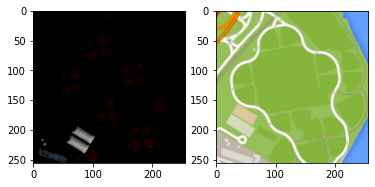

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))           
])
train_dataset = MapDataset('./maps/train/', train_transform, True)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

from utils import *
train_x, train_y = next(iter(train_dataloader))
plot_img_tensor(torch.cat((train_x,train_y), dim=2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])


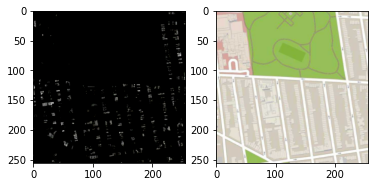

In [10]:
val_transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))           
])
val_dataset = MapDataset('./maps/val/', val_transform, False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_x, test_y = next(iter(val_dataloader))
plot_img_tensor(torch.cat((test_x, test_y), dim=2))

In [11]:
gen = Gen(3).to(DEVICE)
disc = Disc(3).to(DEVICE)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE_GEN, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE_DISC, betas=(0.5, 0.999))

gan_criterion = nn.MSELoss()
l1 = nn.L1Loss()
model_checkpoint = {
    "gen":None,
    "disc":None
}

Gen(
  (init_down): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bottleneck): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (final_up): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (down_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(512, 512, kernel_size=(4, 4

In [ ]:
def sample_images(x, y, mode):
    fake_gen = gen(x)
    x_grid = torchvision.utils.make_grid(x, nrow=1, normalize=True)
    fake_grid = torchvision.utils.make_grid(fake_gen, nrow=1, normalize=True)
    y_grid = torchvision.utils.make_grid(y, nrow=1, normalize=True)
    res_img = torch.cat((x_grid, y_grid, fake_grid), dim=2)
    if mode == "test":
        torchvision.utils.save_image(res_img, "./output_img_testset/epoch_{epoch}_batch_{batch_idx}.png", normalize=False)
    if mode == "train":
        torchvision.utils.save_image(res_img, "./output_img_trainset/epoch_{epoch}_batch_{batch_idx}.png", normalize=False)
    print("saving samples... done!")

def save_checkpoint(dict, path="model.pth.tar"):
    """
    save the model and optim through a dictionary
     {"model": model.state_dict(), "optim": optim.state_dict()} (*)


    params:
        data: a dict of the structure (*) storing the model and optim

    return:
        None
    """
    now = time.strftime("%D_%H:%M")
    print(f"saving checkpoint at {now}, path is '{path}'")
    torch.save(dict, path)
    print("saving model... done!")


In [18]:
for epoch in range(NUM_EPOCH):
    for batch_idx, (x, y) in enumerate(train_dataloader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        gen.train()
        disc.train()

        opt_disc.zero_grad()
        fake_gen = gen(x)
        fake_disc = disc(torch.cat((x, fake_gen), dim=1))
        fake_disc_loss = gan_criterion(fake_disc, torch.zeros_like(fake_disc).to(DEVICE))
        real_disc = disc(torch.cat((x, y), dim=1))
        real_disc_loss = gan_criterion(real_disc, torch.ones_like(real_disc).to(DEVICE))
        disc_loss = fake_disc_loss + real_disc_loss
        disc_loss.backward()
        opt_disc.step()

        opt_gen.zero_grad()
        gen_gan_loss = gan_criterion(fake_disc, torch.ones_like(fake_disc).to(DEVICE))
        gen_l1_loss = l1(fake_gen, y)
        gen_loss = gen_gan_loss + gen_l1_loss
        gen_loss.backward()
        opt_gen.step()



        if batch_idx % 5 == 0:
          gen.eval()
          disc.eval()
          # GAN sample real and gen_result
          
          with torch.no_grad():
             sample_images(train_x, train_y)
             sample_images(test_x, test_y)
    # saving models
    model_checkpoint['gen']=gen.state_dict()
    model_checkpoint['disc']=disc.state_dict()
    save_checkpoint(model_checkpoint)



epoch:[ 0/15], batch[   0/  18], loss:[G:0.725996,D:0.663369]
epoch:[ 0/15], batch[   5/  18], loss:[G:0.781138,D:0.636632]
epoch:[ 0/15], batch[  10/  18], loss:[G:0.773712,D:0.633920]
epoch:[ 0/15], batch[  15/  18], loss:[G:0.758603,D:0.634752]
epoch:[ 1/15], batch[   0/  18], loss:[G:0.763198,D:0.676443]
epoch:[ 1/15], batch[   5/  18], loss:[G:0.769749,D:0.676308]
epoch:[ 1/15], batch[  10/  18], loss:[G:0.771881,D:0.643505]
epoch:[ 1/15], batch[  15/  18], loss:[G:0.783569,D:0.634583]
epoch:[ 2/15], batch[   0/  18], loss:[G:0.796363,D:0.626909]
epoch:[ 2/15], batch[   5/  18], loss:[G:0.786412,D:0.617197]
epoch:[ 2/15], batch[  10/  18], loss:[G:0.776984,D:0.616458]
epoch:[ 2/15], batch[  15/  18], loss:[G:0.759707,D:0.643635]
epoch:[ 3/15], batch[   0/  18], loss:[G:0.767642,D:0.669389]
epoch:[ 3/15], batch[   5/  18], loss:[G:0.745110,D:0.636297]
epoch:[ 3/15], batch[  10/  18], loss:[G:0.773973,D:0.616616]
epoch:[ 3/15], batch[  15/  18], loss:[G:0.765419,D:0.617643]
epoch:[ 

KeyboardInterrupt: ignored